# Connecting to Spark

We're going to be using Python with DataFrames, which is only available in Spark 1.3 or later.  We're going to be using a recent version of open source spark.  To use it, you'll have to import the `SQLContext`.

In [3]:
from pyspark.sql import SQLContext
sql = SQLContext(sc)

Let's set up some common functions

# Reading a table

In [4]:
user = sql.read.format("org.apache.spark.sql.cassandra").\
               load(keyspace="training", table="user")

# Display

In [5]:
user.collect()

[Row(user_id=5, age=10, favorite_foods=[u'Anger'], name=u'Larry'),
 Row(user_id=1, age=34, favorite_foods=[u'Bacon', u'Cheese'], name=u'Jon'),
 Row(user_id=2, age=22, favorite_foods=[u'Kale', u'Pizza', u'Wine'], name=u'Dani'),
 Row(user_id=4, age=1, favorite_foods=[u'Candy', u'Fear'], name=u'Baby Luke'),
 Row(user_id=3, age=108, favorite_foods=[u'Muffins', u'Pie', u'Steak'], name=u'Patrick')]

# Basic Filtering

In [6]:
from pyspark.sql.functions import *

In [5]:
user[user.name == "Jon"].collect()

[Row(user_id=1, age=34, favorite_foods=[u'Bacon', u'Cheese'], name=u'Jon')]

In [6]:
tmp = user.age > 100

In [7]:
user.registerTempTable("user")

In [8]:
tmp = sql.sql("SELECT * from user WHERE name = 'Larry' or age > 30")

In [9]:
tmp.explain()

Filter ((name#3 = Larry) || (age#1 > 30))
 PhysicalRDD [user_id#0,age#1,favorite_foods#2,name#3], MapPartitionsRDD[13] at executedPlan at NativeMethodAccessorImpl.java:-2



In [10]:
user.filter('name = "Larry" or name = "Jon"').show()

+-------+---+--------------------+-----+
|user_id|age|      favorite_foods| name|
+-------+---+--------------------+-----+
|      5| 10|  ArrayBuffer(Anger)|Larry|
|      1| 34|ArrayBuffer(Bacon...|  Jon|
+-------+---+--------------------+-----+



In [10]:
user.filter("age > 100 or name = 'Larry'").collect()

[Row(user_id=3, age=108, favorite_foods=[u'Muffins', u'Pie', u'Steak'], name=u'Patrick'),
 Row(user_id=5, age=10, favorite_foods=[u'Anger'], name=u'Larry')]

In [7]:
user.select(user.name, user.age.alias("years"))

DataFrame[name: string, years: int]

In [12]:
user.select(user.name, user.age.alias("years")).filter("years > 10").collect()

[Row(name=u'Jon', years=34),
 Row(name=u'Dani', years=22),
 Row(name=u'Patrick', years=108)]

In [9]:
user.select(explode(user.favorite_foods)).collect()

[Row(_c0=u'Anger'),
 Row(_c0=u'Bacon'),
 Row(_c0=u'Cheese'),
 Row(_c0=u'Kale'),
 Row(_c0=u'Pizza'),
 Row(_c0=u'Wine'),
 Row(_c0=u'Candy'),
 Row(_c0=u'Fear'),
 Row(_c0=u'Muffins'),
 Row(_c0=u'Pie'),
 Row(_c0=u'Steak')]

In [22]:
# Find users who like a certain food
user.select("user_id", "name", explode(user.favorite_foods).alias("food")).where("food='Bacon'").collect()

[Row(user_id=1, name=u'Jon', food=u'Bacon')]

# A nicer reader

In [23]:
def create_reader(sql, keyspace):
    def reader(table):
        df = sql.read.format("org.apache.spark.sql.cassandra").\
               load(keyspace=keyspace, table=table)
        return df
    return reader

reader = create_reader(sql, "training")

# A Nicer Writer

In [17]:
def create_writer(sql, keyspace, mode="append"):
    def writer(df, table):
        df.write.format("org.apache.spark.sql.cassandra").\
                 options(table=table, keyspace=keyspace).save(mode="append")
    return writer

writer = create_writer(sql, "training")

# Data Migrations

In [25]:

result = user.select(explode(user.favorite_foods).alias("food"), "user_id")
writer(result, "favorite_foods_index")

# SparkSQL

Register dataframe as a table

do whatever you want with it

In [26]:
user.registerTempTable("user")

In [27]:
sql.sql("select * from user where age > 15").collect()

[Row(user_id=1, age=34, favorite_foods=[u'Bacon', u'Cheese'], name=u'Jon'),
 Row(user_id=2, age=22, favorite_foods=[u'Kale', u'Pizza', u'Wine'], name=u'Dani'),
 Row(user_id=3, age=108, favorite_foods=[u'Muffins', u'Pie', u'Steak'], name=u'Patrick')]

# Load the movie lens data

Dataset lives in ml-10M100K directory


In [11]:
movies = sc.textFile("ml-10M100K/movies.dat").map(lambda x: x.split("::") )

In [12]:
movies = movies.map(lambda (x,y,z): (x,y,z.split("|")))

In [13]:
movies = movies.toDF(["movie_id", "name", "tags"])

In [14]:
movies.registerTempTable("movies")

In [15]:
movies.head(10)

[Row(movie_id=u'1', name=u'Toy Story (1995)', tags=[u'Adventure', u'Animation', u'Children', u'Comedy', u'Fantasy']),
 Row(movie_id=u'2', name=u'Jumanji (1995)', tags=[u'Adventure', u'Children', u'Fantasy']),
 Row(movie_id=u'3', name=u'Grumpier Old Men (1995)', tags=[u'Comedy', u'Romance']),
 Row(movie_id=u'4', name=u'Waiting to Exhale (1995)', tags=[u'Comedy', u'Drama', u'Romance']),
 Row(movie_id=u'5', name=u'Father of the Bride Part II (1995)', tags=[u'Comedy']),
 Row(movie_id=u'6', name=u'Heat (1995)', tags=[u'Action', u'Crime', u'Thriller']),
 Row(movie_id=u'7', name=u'Sabrina (1995)', tags=[u'Comedy', u'Romance']),
 Row(movie_id=u'8', name=u'Tom and Huck (1995)', tags=[u'Adventure', u'Children']),
 Row(movie_id=u'9', name=u'Sudden Death (1995)', tags=[u'Action']),
 Row(movie_id=u'10', name=u'GoldenEye (1995)', tags=[u'Action', u'Adventure', u'Thriller'])]

In [18]:
writer(movies, "movie")

In [34]:
sql.sql("SELECT * from movies where movie_id=1").show()

+--------+----------------+--------------------+
|movie_id|            name|                tags|
+--------+----------------+--------------------+
|       1|Toy Story (1995)|ArrayBuffer(Adven...|
+--------+----------------+--------------------+



In [35]:
sql.sql("select * from movies where name like 'Toy%'").show()

+--------+-------------------+--------------------+
|movie_id|               name|                tags|
+--------+-------------------+--------------------+
|       1|   Toy Story (1995)|ArrayBuffer(Adven...|
|    2253|        Toys (1992)|ArrayBuffer(Actio...|
|    3114| Toy Story 2 (1999)|ArrayBuffer(Adven...|
|    4929|    Toy, The (1982)| ArrayBuffer(Comedy)|
|    5843|Toy Soldiers (1991)|ArrayBuffer(Actio...|
+--------+-------------------+--------------------+



In [36]:
sql.sql("select * from movies where name like '%(1981)'").show()

+--------+--------------------+--------------------+
|movie_id|                name|                tags|
+--------+--------------------+--------------------+
|     610|  Heavy Metal (1981)|ArrayBuffer(Actio...|
|     681|Clean Slate (Coup...|  ArrayBuffer(Crime)|
|    1033|Fox and the Hound...|ArrayBuffer(Anima...|
|    1124|On Golden Pond (1...|  ArrayBuffer(Drama)|
|    1129|Escape from New Y...|ArrayBuffer(Actio...|
|    1198|Raiders of the Lo...|ArrayBuffer(Actio...|
|    1233|Boat, The (Das Bo...|ArrayBuffer(Actio...|
|    1264|         Diva (1981)|ArrayBuffer(Actio...|
|    1321|American Werewolf...|ArrayBuffer(Comed...|
|    1335|  Blood Beach (1981)|ArrayBuffer(Actio...|
|    1663|      Stripes (1981)|ArrayBuffer(Comed...|
|    1957|Chariots of Fire ...|  ArrayBuffer(Drama)|
|    1975|Friday the 13th P...| ArrayBuffer(Horror)|
|    1983| Halloween II (1981)| ArrayBuffer(Horror)|
|    2041|    Condorman (1981)|ArrayBuffer(Actio...|
|    2044|Devil and Max Dev...|ArrayBuffer(Com

In [39]:
# UserID::MovieID::Rating::Timestamp
ratings_rdd = sc.textFile("ml-10M100K/ratings.dat").map(lambda x: x.split("::") )

In [40]:
ratings = ratings_rdd.toDF(["user_id", "movie_id", "rating", "timestamp"])

In [42]:
ratings = ratings.select("movie_id", "user_id", "rating", "timestamp")

In [43]:
writer(ratings, "rating_by_movie")

# JOINS and Aggregations

In [44]:
ratings.registerTempTable("ratings")

In [45]:
aggregated_ratings = sql.sql("select movie_id, avg(rating) as rating from ratings group by movie_id")

In [46]:
aggregated_ratings.registerTempTable("average_ratings")

In [47]:
writer(aggregated_ratings, "average_rating")

In [48]:
movies.registerTempTable('movie')

In [49]:
sql.sql("""select movie.movie_id, name, tags, rating FROM movie join average_ratings on movie.movie_id = average_ratings.movie_id  order by rating desc limit 20""").collect()

[Row(movie_id=u'51209', name=u'Fighting Elegy (Kenka erejii) (1966)', tags=[u'Action', u'Comedy'], rating=5.0),
 Row(movie_id=u'33264', name=u"Satan's Tango (S\xe1t\xe1ntang\xf3) (1994)", tags=[u'Drama'], rating=5.0),
 Row(movie_id=u'53355', name=u'Sun Alley (Sonnenallee) (1999)', tags=[u'Comedy', u'Romance'], rating=5.0),
 Row(movie_id=u'42783', name=u'Shadows of Forgotten Ancestors (1964)', tags=[u'Drama', u'Romance'], rating=5.0),
 Row(movie_id=u'64275', name=u'Blue Light, The (Das Blaue Licht) (1932)', tags=[u'Drama', u'Fantasy', u'Mystery'], rating=5.0),
 Row(movie_id=u'26048', name=u'Human Condition II, The (Ningen no joken II) (1959)', tags=[u'Drama', u'War'], rating=4.75),
 Row(movie_id=u'26073', name=u'Human Condition III, The (Ningen no joken III) (1961)', tags=[u'Drama', u'War'], rating=4.75),
 Row(movie_id=u'65001', name=u"Constantine's Sword (2007)", tags=[u'Documentary'], rating=4.75),
 Row(movie_id=u'4454', name=u'More (1998)', tags=[u'Animation', u'IMAX', u'Sci-Fi'], ra

# Top movies for a tag

In [50]:
movies.columns

[u'movie_id', u'name', u'tags']

In [51]:
movies_by_tag = movies.select(explode(movies.tags).alias("tag"), "movie_id", "name")

In [53]:
writer(movies_by_tag, "movies_by_tag")

In [54]:
movies_by_tag.head(10)

[Row(tag=u'Adventure', movie_id=u'1', name=u'Toy Story (1995)'),
 Row(tag=u'Animation', movie_id=u'1', name=u'Toy Story (1995)'),
 Row(tag=u'Children', movie_id=u'1', name=u'Toy Story (1995)'),
 Row(tag=u'Comedy', movie_id=u'1', name=u'Toy Story (1995)'),
 Row(tag=u'Fantasy', movie_id=u'1', name=u'Toy Story (1995)'),
 Row(tag=u'Adventure', movie_id=u'2', name=u'Jumanji (1995)'),
 Row(tag=u'Children', movie_id=u'2', name=u'Jumanji (1995)'),
 Row(tag=u'Fantasy', movie_id=u'2', name=u'Jumanji (1995)'),
 Row(tag=u'Comedy', movie_id=u'3', name=u'Grumpier Old Men (1995)'),
 Row(tag=u'Romance', movie_id=u'3', name=u'Grumpier Old Men (1995)')]

In [55]:
aggregated_ratings.columns

[u'movie_id', u'rating']

In [56]:
#joined = movies.join(movies_by_tag, movies.movie_id == movies_by_tag.movie_id)
movies_by_tag.where(movies_by_tag.tag == "Adventure").\
              join(aggregated_ratings, movies_by_tag.movie_id==aggregated_ratings.movie_id).\
              orderBy(aggregated_ratings.rating, ascending=False).\
              select(movies_by_tag.movie_id, movies_by_tag.name, aggregated_ratings.rating).\
              limit(10).collect()

[Row(movie_id=u'26649', name=u'Lonesome Dove (1989)', rating=4.3076923076923075),
 Row(movie_id=u'908', name=u'North by Northwest (1959)', rating=4.261366341347299),
 Row(movie_id=u'1198', name=u'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', rating=4.261317249919736),
 Row(movie_id=u'25789', name=u'Shanghai Express (1932)', rating=4.25),
 Row(movie_id=u'720', name=u'Wallace & Gromit: The Best of Aardman Animation (1996)', rating=4.22979797979798),
 Row(movie_id=u'260', name=u'Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)', rating=4.2202093397745575),
 Row(movie_id=u'1204', name=u'Lawrence of Arabia (1962)', rating=4.209582164476598),
 Row(movie_id=u'1196', name=u'Star Wars: Episode V - The Empire Strikes Back (1980)', rating=4.1943614395218916),
 Row(movie_id=u'1197', name=u'Princess Bride, The (1987)', rating=4.194158595641646),
 Row(movie_id=u'5618', name=u'Spirited Away (Sen to Chihiro no kamikakushi) (2001)', rating=4.18645294725956

In [60]:
movies_by_tag.show()

+---------+--------+--------------------+
|      tag|movie_id|                name|
+---------+--------+--------------------+
|Adventure|       1|    Toy Story (1995)|
|Animation|       1|    Toy Story (1995)|
| Children|       1|    Toy Story (1995)|
|   Comedy|       1|    Toy Story (1995)|
|  Fantasy|       1|    Toy Story (1995)|
|Adventure|       2|      Jumanji (1995)|
| Children|       2|      Jumanji (1995)|
|  Fantasy|       2|      Jumanji (1995)|
|   Comedy|       3|Grumpier Old Men ...|
|  Romance|       3|Grumpier Old Men ...|
|   Comedy|       4|Waiting to Exhale...|
|    Drama|       4|Waiting to Exhale...|
|  Romance|       4|Waiting to Exhale...|
|   Comedy|       5|Father of the Bri...|
|   Action|       6|         Heat (1995)|
|    Crime|       6|         Heat (1995)|
| Thriller|       6|         Heat (1995)|
|   Comedy|       7|      Sabrina (1995)|
|  Romance|       7|      Sabrina (1995)|
|Adventure|       8| Tom and Huck (1995)|
+---------+--------+--------------

# Pandas and Matplotlib

In [78]:
top_tags = movies.select(explode(movies.tags).alias("tag")).\
                  groupBy("tag").count().\
                  orderBy("count", ascending=False).limit(10)

In [82]:
%matplotlib inline

In [86]:
tags = top_tags.toPandas()
tags

,tag,count
0,Drama,5339
1,Comedy,3703
2,Thriller,1706
3,Romance,1685
4,Action,1473
5,Crime,1118
6,Adventure,1025
7,Horror,1013
8,Sci-Fi,754
9,Fantasy,543


In [84]:
tags.set_index("tag")

,count
tag,
Drama,5339
Comedy,3703
Thriller,1706
Romance,1685
Action,1473
Crime,1118
Adventure,1025
Horror,1013
Sci-Fi,754


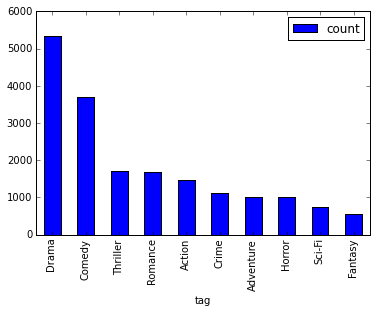

In [85]:
tags.set_index("tag").plot(kind='bar')

# Streaming

In [49]:
from pyspark.sql import Row
ts = str(uuid1())
print ts
data = [Row(movie_id=329, rating=4, user_id=53974, ts=ts), 
        Row(movie_id=329, rating=3, user_id=4324, ts=ts), 
        Row(movie_id=329, rating=2, user_id=101, ts=ts), 
        Row(movie_id=329, rating=3, user_id=7192, ts=ts), 
        Row(movie_id=580, rating=4, user_id=2538, ts=ts), 
        Row(movie_id=250, rating=5, user_id=2678, ts=ts), 
        Row(movie_id=311, rating=1, user_id=1438, ts=ts), 
        Row(movie_id=856, rating=4, user_id=6376, ts=ts), 
        Row(movie_id=954, rating=3, user_id=1282, ts=ts), 
        Row(movie_id=20, rating=2, user_id=4412, ts=ts)]

df = sql.createDataFrame(data)
df.registerTempTable("ratings")


549588d9-29de-11e5-9252-3c15c2c26c1e


In [57]:
movie_to_ts = sql.sql("select distinct movie_id, ts from ratings")
movie_to_ts.registerTempTable("movie_ts")

In [54]:
movie_to_ts.collect()

[Row(movie_id=329, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=250, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=580, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=856, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=954, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=311, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=20, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e')]

In [55]:
agg = sql.sql("SELECT movie_id, avg(rating) as a, count(rating) as c from ratings group by movie_id")

In [56]:
agg.registerTempTable("movie_aggregates")

In [52]:
agg.collect()

[Row(movie_id=250, c1=5.0, c2=1),
 Row(movie_id=856, c1=4.0, c2=1),
 Row(movie_id=311, c1=1.0, c2=1),
 Row(movie_id=329, c1=3.0, c2=4),
 Row(movie_id=954, c1=3.0, c2=1),
 Row(movie_id=580, c1=4.0, c2=1),
 Row(movie_id=20, c1=2.0, c2=1)]

In [59]:
sql.sql("select a.movie_id, a.a, a.c, b.ts as ts from movie_aggregates a join movie_ts b on a.movie_id = b.movie_id  ").collect()

[Row(movie_id=250, a=5.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=856, a=4.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=311, a=1.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=329, a=3.0, c=4, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=954, a=3.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=580, a=4.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e'),
 Row(movie_id=20, a=2.0, c=1, ts=u'549588d9-29de-11e5-9252-3c15c2c26c1e')]

In [20]:
from pyspark.sql import functions as F

In [35]:
# adding a field to a dataframe
from uuid import uuid1

df.fillna({"timestamp":str(uuid1())}).collect()

Py4JJavaError: An error occurred while calling o473.fill.
: org.apache.spark.sql.AnalysisException: Cannot resolve column name "timestamp" among (movie_id, rating, user_id);
	at org.apache.spark.sql.DataFrame$$anonfun$resolve$1.apply(DataFrame.scala:159)
	at org.apache.spark.sql.DataFrame$$anonfun$resolve$1.apply(DataFrame.scala:159)
	at scala.Option.getOrElse(Option.scala:120)
	at org.apache.spark.sql.DataFrame.resolve(DataFrame.scala:158)
	at org.apache.spark.sql.DataFrameNaFunctions$$anonfun$fill0$1.apply(DataFrameNaFunctions.scala:364)
	at org.apache.spark.sql.DataFrameNaFunctions$$anonfun$fill0$1.apply(DataFrameNaFunctions.scala:362)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.sql.DataFrameNaFunctions.fill0(DataFrameNaFunctions.scala:362)
	at org.apache.spark.sql.DataFrameNaFunctions.fill(DataFrameNaFunctions.scala:210)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


In [24]:
df.groupBy("movie_id").agg(F.avg(df.rating).alias('avg'), F.count(df.rating).alias('count')).collect()

[Row(movie_id=250, avg=5.0, count=1),
 Row(movie_id=856, avg=4.0, count=1),
 Row(movie_id=709, avg=3.0, count=1),
 Row(movie_id=311, avg=1.0, count=1),
 Row(movie_id=324, avg=3.0, count=1),
 Row(movie_id=926, avg=2.0, count=1),
 Row(movie_id=329, avg=4.0, count=1),
 Row(movie_id=954, avg=3.0, count=1),
 Row(movie_id=580, avg=4.0, count=1),
 Row(movie_id=20, avg=2.0, count=1)]

In [34]:
agg = df.groupBy("movie_id").\
   agg(F.avg(df.rating).alias("avg"), 
       F.count(df.rating).alias('count'), 
       F.max(df.timestamp).alias("timestamp"))

In [33]:
# create table movie_stream_ratings ( movie_id int, ts float, avg float, c int, primary key (movie_id, ts) );

In [40]:
writer(agg.select("movie_id", "timestamp", "avg", "count"), "movie_stream_ratings")

Py4JJavaError: An error occurred while calling o411.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 19 in stage 29.0 failed 4 times, most recent failure: Lost task 19.3 in stage 29.0 (TID 1690, 192.168.1.13): com.datastax.spark.connector.types.TypeConversionException: Cannot convert object 1436566541 of type class java.lang.Long to java.util.UUID.
	at com.datastax.spark.connector.types.TypeConverter$$anonfun$convert$1.apply(TypeConverter.scala:42)
	at com.datastax.spark.connector.types.TypeConverter$$anonfun$convert$1.apply(TypeConverter.scala:40)
	at com.datastax.spark.connector.types.TypeConverter$UUIDConverter$$anonfun$convertPF$18.applyOrElse(TypeConverter.scala:393)
	at com.datastax.spark.connector.types.TypeConverter$class.convert(TypeConverter.scala:40)
	at com.datastax.spark.connector.types.TypeConverter$UUIDConverter$.com$datastax$spark$connector$types$NullableTypeConverter$$super$convert(TypeConverter.scala:391)
	at com.datastax.spark.connector.types.NullableTypeConverter$class.convert(TypeConverter.scala:53)
	at com.datastax.spark.connector.types.TypeConverter$UUIDConverter$.convert(TypeConverter.scala:391)
	at com.datastax.spark.connector.types.TypeConverter$OptionToNullConverter$$anonfun$convertPF$26.applyOrElse(TypeConverter.scala:702)
	at com.datastax.spark.connector.types.TypeConverter$class.convert(TypeConverter.scala:40)
	at com.datastax.spark.connector.types.TypeConverter$OptionToNullConverter.com$datastax$spark$connector$types$NullableTypeConverter$$super$convert(TypeConverter.scala:695)
	at com.datastax.spark.connector.types.NullableTypeConverter$class.convert(TypeConverter.scala:53)
	at com.datastax.spark.connector.types.TypeConverter$OptionToNullConverter.convert(TypeConverter.scala:695)
	at com.datastax.spark.connector.writer.SqlRowWriter$$anonfun$readColumnValues$1.apply$mcVI$sp(SqlRowWriter.scala:21)
	at scala.collection.immutable.Range.foreach$mVc$sp(Range.scala:141)
	at com.datastax.spark.connector.writer.SqlRowWriter.readColumnValues(SqlRowWriter.scala:20)
	at com.datastax.spark.connector.writer.SqlRowWriter.readColumnValues(SqlRowWriter.scala:8)
	at com.datastax.spark.connector.writer.BoundStatementBuilder.bind(BoundStatementBuilder.scala:35)
	at com.datastax.spark.connector.writer.GroupingBatchBuilder.next(GroupingBatchBuilder.scala:106)
	at com.datastax.spark.connector.writer.GroupingBatchBuilder.next(GroupingBatchBuilder.scala:31)
	at scala.collection.Iterator$class.foreach(Iterator.scala:727)
	at com.datastax.spark.connector.writer.GroupingBatchBuilder.foreach(GroupingBatchBuilder.scala:31)
	at com.datastax.spark.connector.writer.TableWriter$$anonfun$write$1.apply(TableWriter.scala:155)
	at com.datastax.spark.connector.writer.TableWriter$$anonfun$write$1.apply(TableWriter.scala:139)
	at com.datastax.spark.connector.cql.CassandraConnector$$anonfun$withSessionDo$1.apply(CassandraConnector.scala:108)
	at com.datastax.spark.connector.cql.CassandraConnector$$anonfun$withSessionDo$1.apply(CassandraConnector.scala:107)
	at com.datastax.spark.connector.cql.CassandraConnector.closeResourceAfterUse(CassandraConnector.scala:137)
	at com.datastax.spark.connector.cql.CassandraConnector.withSessionDo(CassandraConnector.scala:107)
	at com.datastax.spark.connector.writer.TableWriter.write(TableWriter.scala:139)
	at com.datastax.spark.connector.RDDFunctions$$anonfun$saveToCassandra$1.apply(RDDFunctions.scala:36)
	at com.datastax.spark.connector.RDDFunctions$$anonfun$saveToCassandra$1.apply(RDDFunctions.scala:36)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:63)
	at org.apache.spark.scheduler.Task.run(Task.scala:70)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:213)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1266)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1257)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1256)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1256)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:730)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:730)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:730)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1450)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1411)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
